In [208]:
import pandas as pd
import numpy as np


In [209]:
df =  pd.read_csv('/content/final_dataset (1).csv')

In [210]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["quantity"] = df["quantity"].astype(int)
df["unit_price"] = df["unit_price"].astype(float)
df["discount_pct"] = df["discount_pct"].astype(float)

print(df.shape)
df.head()

(50000, 18)


,product_id,category,unit_price,is_discountable,store_id,store_type,region,city,customer_id,gender,age,loyalty_tier,preferred_channel,transaction_id,transaction_date,channel,quantity,discount_pct
0,P0200,Home,106.31,1,S007,Outlet,Central,Grandview,C00010,M,42,Bronze,Mobile,T0042714,2025-08-01,InStore,2,0.0
1,P0140,Grocery,9.13,1,S017,Street,Central,Centrum,C00094,F,31,Bronze,InStore,T0024445,2025-08-01,InStore,1,0.0
2,P0225,Beauty,16.93,0,S038,Mall,South,Southport,C00164,M,25,Bronze,InStore,T0008413,2025-08-01,Online,2,0.0
3,P0105,Grocery,13.08,1,S039,Street,East,Rivermouth,C00197,F,24,Bronze,Online,T0037032,2025-08-01,Mobile,2,0.0
4,P0103,Home,143.33,1,S023,Mall,East,Rivermouth,C00104,M,25,Gold,InStore,T0024521,2025-08-01,InStore,1,0.0


In [211]:
df["effective_price"] = df["unit_price"] * (1 - df["discount_pct"])
df["total_amount"] = df["effective_price"] * df["quantity"]


In [212]:
df.head(5)

,product_id,category,unit_price,is_discountable,store_id,store_type,region,city,customer_id,gender,age,loyalty_tier,preferred_channel,transaction_id,transaction_date,channel,quantity,discount_pct,effective_price,total_amount
0,P0200,Home,106.31,1,S007,Outlet,Central,Grandview,C00010,M,42,Bronze,Mobile,T0042714,2025-08-01,InStore,2,0.0,106.31,212.62
1,P0140,Grocery,9.13,1,S017,Street,Central,Centrum,C00094,F,31,Bronze,InStore,T0024445,2025-08-01,InStore,1,0.0,9.13,9.13
2,P0225,Beauty,16.93,0,S038,Mall,South,Southport,C00164,M,25,Bronze,InStore,T0008413,2025-08-01,Online,2,0.0,16.93,33.86
3,P0105,Grocery,13.08,1,S039,Street,East,Rivermouth,C00197,F,24,Bronze,Online,T0037032,2025-08-01,Mobile,2,0.0,13.08,26.16
4,P0103,Home,143.33,1,S023,Mall,East,Rivermouth,C00104,M,25,Gold,InStore,T0024521,2025-08-01,InStore,1,0.0,143.33,143.33


In [213]:
df = df[(df["quantity"] > 0) & (df["total_amount"] > 0)]
df = df[df["customer_id"].notna()]
df = df[df["transaction_date"].notna()]



In [214]:
cutoff_date = pd.to_datetime("2025-12-01")


In [215]:
past_df = df[df["transaction_date"] < cutoff_date]


In [216]:
future_df = df[
    (df["transaction_date"] >= cutoff_date) &
    (df["transaction_date"] < cutoff_date + pd.Timedelta(days=30))
]


In [217]:
frequency_df = (
    past_df.groupby("customer_id")["transaction_id"]
    .nunique()
    .reset_index(name="frequency")
)


In [218]:
monetary_df = (
    past_df.groupby("customer_id")["total_amount"]
    .sum()
    .reset_index(name="monetary")
)


In [219]:
last_purchase_df = (
    past_df.groupby("customer_id")["transaction_date"]
    .max()
    .reset_index(name="last_purchase_date")
)

last_purchase_df["recency"] = (
    cutoff_date - last_purchase_df["last_purchase_date"]
).dt.days



In [220]:
rfm = (
    frequency_df
    .merge(monetary_df, on="customer_id")
    .merge(
        last_purchase_df[["customer_id", "recency"]],
        on="customer_id"
    )
)


In [221]:
target_df = (
    future_df.groupby("customer_id")["total_amount"]
    .sum()
    .reset_index(name="spend_next_30_days")
)


In [222]:
final_df = rfm.merge(
    target_df,
    on="customer_id",
    how="left"
)


In [223]:
final_df["spend_next_30_days"] = final_df["spend_next_30_days"].fillna(0)


In [224]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         250 non-null    object 
 1   frequency           250 non-null    int64  
 2   monetary            250 non-null    float64
 3   recency             250 non-null    int64  
 4   spend_next_30_days  250 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.9+ KB


In [225]:
final_df.describe()


,frequency,monetary,recency,spend_next_30_days
count,250.000000,250.000000,250.00000,250.000000
mean,159.308000,25356.775272,1.30800,6125.093852
std,55.462179,17804.756312,0.70933,4349.835725
min,47.000000,2494.935000,1.00000,195.589500
25%,121.000000,13424.513750,1.00000,3130.963750
50%,157.000000,19369.885750,1.00000,4818.162500
75%,194.750000,31232.588125,1.00000,7851.466875
max,350.000000,101458.522000,5.00000,24959.760000


In [226]:
final_df.head()


,customer_id,frequency,monetary,recency,spend_next_30_days
0,C00001,112,14071.8560,3,3362.3300
1,C00002,191,19481.5430,1,3066.2355
2,C00003,235,73037.3575,1,20788.1415
3,C00004,226,29091.6140,1,8838.9960
4,C00005,145,14481.3760,1,2013.3560


In [227]:
customer_features = (
    past_df.groupby("customer_id")
    .agg(
        gender=("gender", "first"),
        age=("age", "first"),
        loyalty_tier=("loyalty_tier", "first"),
        preferred_channel=("preferred_channel", "first"),
        city=("city", "first"),
        region=("region", "first"),
        store_type=("store_type", lambda x: x.mode()[0]),
        avg_discount=("discount_pct", "mean"),
        avg_unit_price=("unit_price", "mean"),
        total_quantity=("quantity", "sum"),
        unique_products=("product_id", "nunique"),
        unique_categories=("category", "nunique"),
        unique_channels=("channel", "nunique")
    )
    .reset_index()
)


In [228]:
final_customer_df = (
    customer_features
    .merge(rfm, on="customer_id")
    .merge(target_df, on="customer_id", how="left")
)


In [229]:
final_customer_df["spend_next_30_days"] = (
    final_customer_df["spend_next_30_days"].fillna(0)
)


In [230]:
final_customer_df.isna().sum()


,0
customer_id,0
gender,0
age,0
loyalty_tier,0
preferred_channel,0
city,0
region,0
store_type,0
avg_discount,0
avg_unit_price,0


In [231]:
final_customer_df.head()


,customer_id,gender,age,loyalty_tier,preferred_channel,city,region,store_type,avg_discount,avg_unit_price,total_quantity,unique_products,unique_categories,unique_channels,frequency,monetary,recency,spend_next_30_days
0,C00001,M,41,Bronze,Mobile,Baytown,South,OnlineHub,0.034821,99.003661,170,89,6,3,112,14071.8560,3,3362.3300
1,C00002,M,33,Bronze,InStore,Southport,South,OnlineHub,0.017539,81.120890,255,89,6,3,191,19481.5430,1,3066.2355
2,C00003,M,43,Platinum,InStore,Easton,East,Street,0.027447,254.423106,316,108,6,3,235,73037.3575,1,20788.1415
3,C00004,F,53,Gold,InStore,Southport,South,OnlineHub,0.027876,103.938628,312,126,6,3,226,29091.6140,1,8838.9960
4,C00005,F,32,Bronze,Mobile,Frostford,North,Outlet,0.027586,83.861034,182,81,6,3,145,14481.3760,1,2013.3560


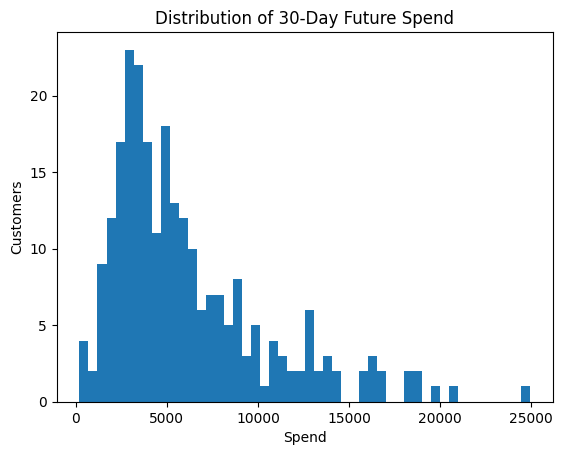

In [232]:
import matplotlib.pyplot as plt

plt.hist(final_customer_df["spend_next_30_days"], bins=50)
plt.title("Distribution of 30-Day Future Spend")
plt.xlabel("Spend")
plt.ylabel("Customers")
plt.show()


In [233]:
(final_customer_df["spend_next_30_days"] == 0).mean()


np.float64(0.0)

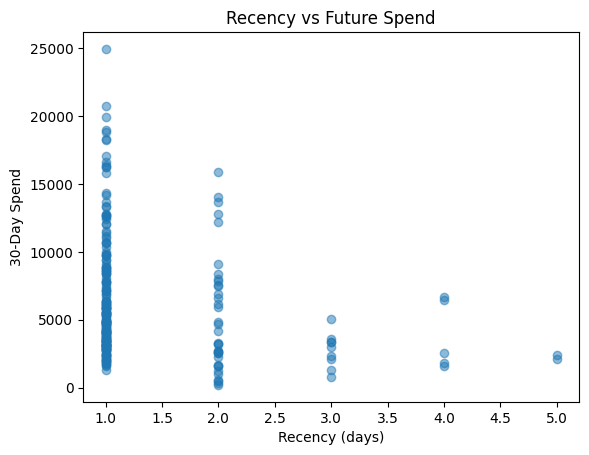

In [234]:
plt.scatter(
    final_customer_df["recency"],
    final_customer_df["spend_next_30_days"],
    alpha=0.5
)
plt.xlabel("Recency (days)")
plt.ylabel("30-Day Spend")
plt.title("Recency vs Future Spend")
plt.show()


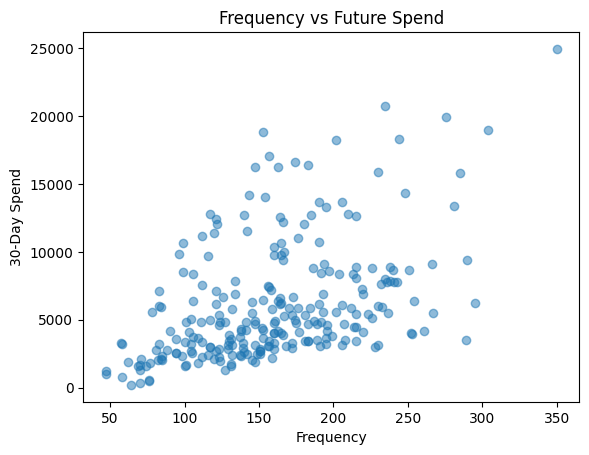

In [235]:
plt.scatter(
    final_customer_df["frequency"],
    final_customer_df["spend_next_30_days"],
    alpha=0.5
)
plt.xlabel("Frequency")
plt.ylabel("30-Day Spend")
plt.title("Frequency vs Future Spend")
plt.show()



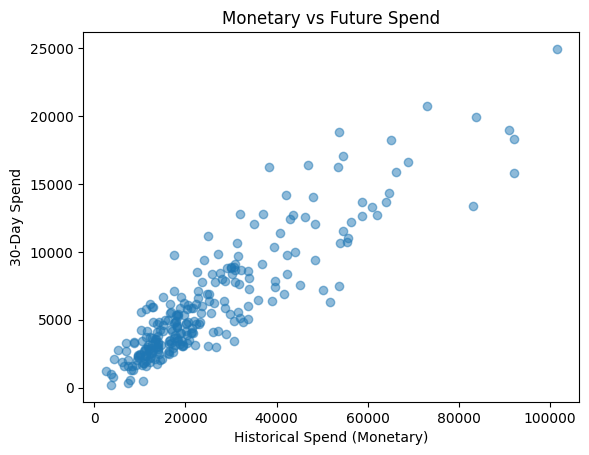

In [236]:
plt.scatter(
    final_customer_df["monetary"],
    final_customer_df["spend_next_30_days"],
    alpha=0.5
)
plt.xlabel("Historical Spend (Monetary)")
plt.ylabel("30-Day Spend")
plt.title("Monetary vs Future Spend")
plt.show()


In [237]:
final_customer_df

,customer_id,gender,age,loyalty_tier,preferred_channel,city,region,store_type,avg_discount,avg_unit_price,total_quantity,unique_products,unique_categories,unique_channels,frequency,monetary,recency,spend_next_30_days
0,C00001,M,41,Bronze,Mobile,Baytown,South,OnlineHub,0.034821,99.003661,170,89,6,3,112,14071.8560,3,3362.3300
1,C00002,M,33,Bronze,InStore,Southport,South,OnlineHub,0.017539,81.120890,255,89,6,3,191,19481.5430,1,3066.2355
2,C00003,M,43,Platinum,InStore,Easton,East,Street,0.027447,254.423106,316,108,6,3,235,73037.3575,1,20788.1415
3,C00004,F,53,Gold,InStore,Southport,South,OnlineHub,0.027876,103.938628,312,126,6,3,226,29091.6140,1,8838.9960
4,C00005,F,32,Bronze,Mobile,Frostford,North,Outlet,0.027586,83.861034,182,81,6,3,145,14481.3760,1,2013.3560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,C00246,F,31,Gold,Online,Rivermouth,East,Street,0.022558,60.102233,345,128,6,3,215,18046.3810,1,3465.4115
246,C00247,F,29,Bronze,InStore,Frostford,North,Outlet,0.020714,79.030714,108,60,6,3,70,7308.9005,2,369.5180
247,C00248,F,27,Bronze,Mobile,Southport,South,OnlineHub,0.018902,71.473902,134,66,5,3,82,7430.3830,1,2059.5935
248,C00249,F,56,Silver,InStore,Easton,East,Street,0.028526,235.567564,264,94,6,3,156,53736.9260,2,7458.3630


In [238]:
cutoff_date = pd.to_datetime("2025-12-01")

past_df = df[df["transaction_date"] < cutoff_date]


In [239]:
last_30_start = cutoff_date - pd.Timedelta(days=30)
last_90_start = cutoff_date - pd.Timedelta(days=90)


In [240]:
spend_30 = (
    past_df[past_df["transaction_date"] >= last_30_start]
    .groupby("customer_id")["total_amount"]
    .sum()
    .reset_index(name="spend_last_30_days")
)


In [241]:
spend_90 = (
    past_df[past_df["transaction_date"] >= last_90_start]
    .groupby("customer_id")["total_amount"]
    .sum()
    .reset_index(name="spend_last_90_days")
)


In [242]:
final_customer_df = final_customer_df.merge(
    spend_30, on="customer_id", how="left"
).merge(
    spend_90, on="customer_id", how="left"
)


In [243]:
final_customer_df[["spend_last_30_days", "spend_last_90_days"]] = (
    final_customer_df[["spend_last_30_days", "spend_last_90_days"]]
    .fillna(0)
)


In [244]:
final_customer_df["spend_velocity"] = np.where(
    final_customer_df["spend_last_90_days"] > 0,
    final_customer_df["spend_last_30_days"] / final_customer_df["spend_last_90_days"],
    0
)


In [245]:
final_customer_df["spend_velocity"].describe()


,spend_velocity
count,250.000000
mean,0.342057
std,0.082091
min,0.146746
25%,0.289360
50%,0.341972
75%,0.400176
max,0.620085


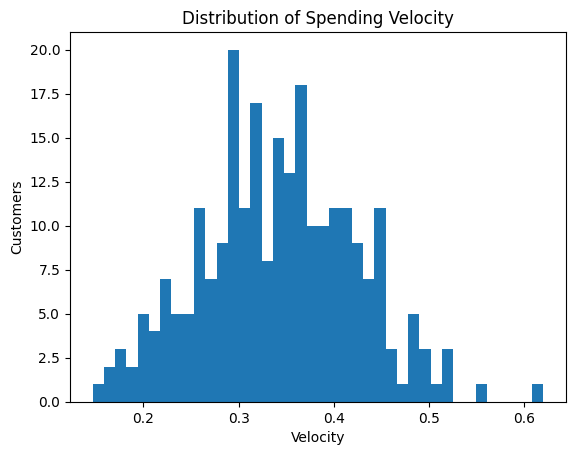

In [246]:
import matplotlib.pyplot as plt

plt.hist(final_customer_df["spend_velocity"], bins=40)
plt.title("Distribution of Spending Velocity")
plt.xlabel("Velocity")
plt.ylabel("Customers")
plt.show()


In [247]:
final_customer_df["velocity_segment"] = np.select(
    [
        final_customer_df["spend_velocity"] == 0,
        final_customer_df["spend_velocity"] < 0,
        final_customer_df["spend_velocity"] > 0
    ],
    [
        "Inactive",
        "Declining",
        "Accelerating"
    ],
    default="Stable"
)


In [248]:
final_customer_df.head(10)

,customer_id,gender,age,loyalty_tier,preferred_channel,city,region,store_type,avg_discount,avg_unit_price,...,unique_categories,unique_channels,frequency,monetary,recency,spend_next_30_days,spend_last_30_days,spend_last_90_days,spend_velocity,velocity_segment
0,C00001,M,41,Bronze,Mobile,Baytown,South,OnlineHub,0.034821,99.003661,...,6,3,112,14071.8560,3,3362.3300,2109.3975,11216.6260,0.188060,Accelerating
1,C00002,M,33,Bronze,InStore,Southport,South,OnlineHub,0.017539,81.120890,...,6,3,191,19481.5430,1,3066.2355,6508.9615,16059.2315,0.405310,Accelerating
2,C00003,M,43,Platinum,InStore,Easton,East,Street,0.027447,254.423106,...,6,3,235,73037.3575,1,20788.1415,13737.7490,54901.0630,0.250227,Accelerating
3,C00004,F,53,Gold,InStore,Southport,South,OnlineHub,0.027876,103.938628,...,6,3,226,29091.6140,1,8838.9960,6027.0010,21331.8865,0.282535,Accelerating
4,C00005,F,32,Bronze,Mobile,Frostford,North,Outlet,0.027586,83.861034,...,6,3,145,14481.3760,1,2013.3560,4065.3905,11498.4005,0.353561,Accelerating
5,C00006,M,32,Gold,InStore,Winterton,North,Outlet,0.030478,105.739323,...,6,3,251,30902.5585,1,8629.4400,8806.2955,24450.4240,0.360169,Accelerating
6,C00007,O,54,Silver,InStore,Grandview,Central,Street,0.019811,88.930849,...,6,3,106,11311.4685,1,3733.7590,3671.7595,8725.8835,0.420789,Accelerating
7,C00008,M,44,Gold,InStore,Southport,South,OnlineHub,0.020219,190.125355,...,6,3,183,46912.5880,1,16367.9330,11303.6245,33505.7935,0.337363,Accelerating
8,C00009,F,29,Gold,InStore,Rivermouth,East,Street,0.021523,55.849338,...,6,3,151,10937.4990,2,2678.6860,2999.9175,8325.6955,0.360320,Accelerating
9,C00010,M,42,Bronze,Mobile,Grandview,Central,Street,0.028960,131.360495,...,6,3,202,31488.2365,1,5605.3640,8262.1695,22672.2185,0.364418,Accelerating


In [249]:
final_customer_df = final_customer_df.drop(columns=["velocity_segment"])


In [250]:
cols = [c for c in final_customer_df.columns if c != "spend_next_30_days"]
final_customer_df = final_customer_df[cols + ["spend_next_30_days"]]


In [251]:
final_customer_df.head(10)

,customer_id,gender,age,loyalty_tier,preferred_channel,city,region,store_type,avg_discount,avg_unit_price,...,unique_products,unique_categories,unique_channels,frequency,monetary,recency,spend_last_30_days,spend_last_90_days,spend_velocity,spend_next_30_days
0,C00001,M,41,Bronze,Mobile,Baytown,South,OnlineHub,0.034821,99.003661,...,89,6,3,112,14071.8560,3,2109.3975,11216.6260,0.188060,3362.3300
1,C00002,M,33,Bronze,InStore,Southport,South,OnlineHub,0.017539,81.120890,...,89,6,3,191,19481.5430,1,6508.9615,16059.2315,0.405310,3066.2355
2,C00003,M,43,Platinum,InStore,Easton,East,Street,0.027447,254.423106,...,108,6,3,235,73037.3575,1,13737.7490,54901.0630,0.250227,20788.1415
3,C00004,F,53,Gold,InStore,Southport,South,OnlineHub,0.027876,103.938628,...,126,6,3,226,29091.6140,1,6027.0010,21331.8865,0.282535,8838.9960
4,C00005,F,32,Bronze,Mobile,Frostford,North,Outlet,0.027586,83.861034,...,81,6,3,145,14481.3760,1,4065.3905,11498.4005,0.353561,2013.3560
5,C00006,M,32,Gold,InStore,Winterton,North,Outlet,0.030478,105.739323,...,108,6,3,251,30902.5585,1,8806.2955,24450.4240,0.360169,8629.4400
6,C00007,O,54,Silver,InStore,Grandview,Central,Street,0.019811,88.930849,...,65,6,3,106,11311.4685,1,3671.7595,8725.8835,0.420789,3733.7590
7,C00008,M,44,Gold,InStore,Southport,South,OnlineHub,0.020219,190.125355,...,90,6,3,183,46912.5880,1,11303.6245,33505.7935,0.337363,16367.9330
8,C00009,F,29,Gold,InStore,Rivermouth,East,Street,0.021523,55.849338,...,95,6,3,151,10937.4990,2,2999.9175,8325.6955,0.360320,2678.6860
9,C00010,M,42,Bronze,Mobile,Grandview,Central,Street,0.028960,131.360495,...,92,6,3,202,31488.2365,1,8262.1695,22672.2185,0.364418,5605.3640


In [266]:
final_customer_df.to_csv('final_customer_df.csv', index=False)


In [253]:
df_model = final_customer_df.copy()

target = "spend_next_30_days"

X = df_model.drop(columns=[target, "customer_id"])
y = df_model[target]


In [255]:
categorical_cols = [
    "gender",
    "loyalty_tier",
    "preferred_channel",
    "city",
    "region",
    "store_type"
]

numerical_cols = [
    "age",
    "avg_discount",
    "avg_unit_price",
    "unique_products",
    "unique_categories",
    "unique_channels",
    "frequency",
    "monetary",
    "recency",
    "spend_last_30_days",
    "spend_last_90_days",
    "spend_velocity"
]


In [257]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [258]:
from sklearn.model_selection import train_test_split

# Split dataset into 85% train and 15% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)


In [259]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ]
)


In [260]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'avg_discount',
                                                   'avg_unit_price',
                                                   'unique_products',
                                                   'unique_categories',
                                                   'unique_channels',
                                                   'frequency', 'monetary',
                                                   'recency',
                                                   'spend_last_30_days',
                                                   'spend_last_90_days',
                                                   'spend_velocity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'loyalty_tier',
                                                   'preferred_channel', 'city',
                                                   'region', 'store_type'])])),
                ('regressor', LinearRegression())])

In [262]:
y_test_pred = model.predict(X_test)

# Evaluate
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("Test MSE :", mse_test)
print("Test RMSE:", rmse_test)
print("Test R²  :", r2_test)

Test MSE : 4302030.898624928
Test RMSE: 2074.133770667873
Test R²  : 0.7778388176528632


In [263]:
import xgboost as xgb

# Replace regressor with XGBoost Regressor in the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_test_pred = model.predict(X_test)

# Evaluate
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("XGBoost Test MSE :", mse_test)
print("XGBoost Test RMSE:", rmse_test)
print("XGBoost Test R²  :", r2_test)


XGBoost Test MSE : 4923079.725159628
XGBoost Test RMSE: 2218.801416341631
XGBoost Test R²  : 0.7457672345216607


In [264]:
from sklearn.ensemble import RandomForestRegressor

# Replace regressor with Random Forest Regressor in the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_test_pred = model.predict(X_test)

# Evaluate
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("Random Forest Test MSE :", mse_test)
print("Random Forest Test RMSE:", rmse_test)
print("Random Forest Test R²  :", r2_test)


Random Forest Test MSE : 4554292.819995503
Random Forest Test RMSE: 2134.0789160655477
Random Forest Test R²  : 0.7648117594951078


In [265]:
import joblib

# Save the pipeline to a file
joblib.dump(model, 'spend_predictor_pipeline.pkl')


['spend_predictor_pipeline.pkl']

In [269]:
import gradio as gr
import pandas as pd
import joblib

# Load your original dataset (features)
df = pd.read_csv('/content/final_customer_df.csv')  # or however you load it
df.set_index('customer_id', inplace=True)

# Load the saved model pipeline
model = joblib.load('spend_predictor_pipeline.pkl')

def predict_spend(customer_id):
    # Check if customer_id exists
    if customer_id not in df.index:
        return f"Customer ID '{customer_id}' not found."

    # Get features for this customer as DataFrame with one row
    customer_features = df.loc[[customer_id]].drop(columns=['spend_next_30_days'])

    # Predict next 30 days spend
    pred = model.predict(customer_features)[0]

    return f"Predicted spend for next 30 days: ${pred:.2f}"

# Gradio UI
iface = gr.Interface(
    fn=predict_spend,
    inputs=gr.Textbox(label="Customer ID"),
    outputs=gr.Textbox(label="Next 30 Days Spend Prediction"),
    title="Customer Spend Predictor",
    description="Enter a Customer ID to predict their spend for the next 30 days."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://303b144df3d053f09a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
